In [1]:
# Standard imports
import sys
import 
import os
import pandas as pd
import numpy as np
import textwrap
import matplotlib.pyplot as plt
%matplotlib inline

# ML
import tensorflow_hub as hub
import tensorflow as tf
from langdetect import detect

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
SEED=1

# Plotly
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio
init_notebook_mode(connected=True)

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

# Cell timing
# https://github.com/cpcloud/ipython-autotime
%load_ext autotime

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Amazon product reviews

* https://s3.amazonaws.com/amazon-reviews-pds/readme.html

```
wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Camera_v1_00.tsv.gz
gunzip amazon_reviews_us_Camera_v1_00.tsv.gz
```

In [2]:
# Load our dataset (first time)
df = pd.read_csv('data/amazon_reviews_us_Camera_v1_00.tsv', sep='\t', error_bad_lines=False)
df = df.loc[df.product_title=='GoPro Head Strap Mount',['review_id','star_rating','review_headline','review_body','review_date']]
df['age'] = pd.datetime.today() - pd.to_datetime(df.review_date)
df['age'] = df.age.dt.days
df['review_body'] = df.review_body.map(lambda x: str(x))
df['review_headline'] = df.review_headline.map(lambda x: str(x))
df['textwrap'] = df.review_body.map(lambda x: '<br>'.join(textwrap.wrap(x, 64)))

# Save it
df.to_csv('output/gopro_strap.tsv', index=False, sep='\t')

b'Skipping line 85458: expected 15 fields, saw 22\nSkipping line 91161: expected 15 fields, saw 22\n'
b'Skipping line 166123: expected 15 fields, saw 22\n'
b'Skipping line 225458: expected 15 fields, saw 22\nSkipping line 229936: expected 15 fields, saw 22\nSkipping line 259297: expected 15 fields, saw 22\n'
b'Skipping line 284728: expected 15 fields, saw 22\nSkipping line 286334: expected 15 fields, saw 22\nSkipping line 293400: expected 15 fields, saw 22\nSkipping line 294415: expected 15 fields, saw 22\nSkipping line 308150: expected 15 fields, saw 22\nSkipping line 315022: expected 15 fields, saw 22\nSkipping line 315730: expected 15 fields, saw 22\nSkipping line 316071: expected 15 fields, saw 22\nSkipping line 326729: expected 15 fields, saw 22\n'
b'Skipping line 329101: expected 15 fields, saw 22\nSkipping line 333077: expected 15 fields, saw 22\nSkipping line 377031: expected 15 fields, saw 22\nSkipping line 389496: expected 15 fields, saw 22\nSkipping line 390486: expected 15 

KeyboardInterrupt: 

time: 8.43 s


In [ ]:
# Reload our dataset (if first step already done)
#df = pd.read_csv('gopro_strap.tsv', sep='\t')

sentences = df.review_body.tolist()

In [5]:
# Load Google model from Tensorflow Hub
guse = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")

# Function which will take a list of strings (sentences) and return the GUSE vectors
def guse_vectors(x):
  embeddings = guse(x)
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    return sess.run(embeddings)

time: 1.64 s


In [10]:
# Generate GUSE vectors - batch process 1000 at a time
batch_size = 2000
sentences_batch = [sentences[i:i+batch_size] for i in range(0,len(sentences),batch_size)]
vectors_guse_batch = [guse_vectors(x) for x in sentences_batch]
vectors_guse = np.concatenate(vectors_guse_batch, axis=0)

time: 3min 56s


In [11]:
np.save('vectors-gopro.npy', vectors_guse)

time: 64.6 ms


In [12]:
embedding_pca = PCA(n_components=2).fit_transform(vectors_guse)

time: 89 ms


In [13]:
embedding_tsne = TSNE(n_components=2, random_state=SEED).fit_transform(vectors_guse)

time: 3min 26s


In [14]:
embedding_umap = umap.UMAP(n_components=2, random_state=SEED).fit_transform(vectors_guse)

time: 18 s


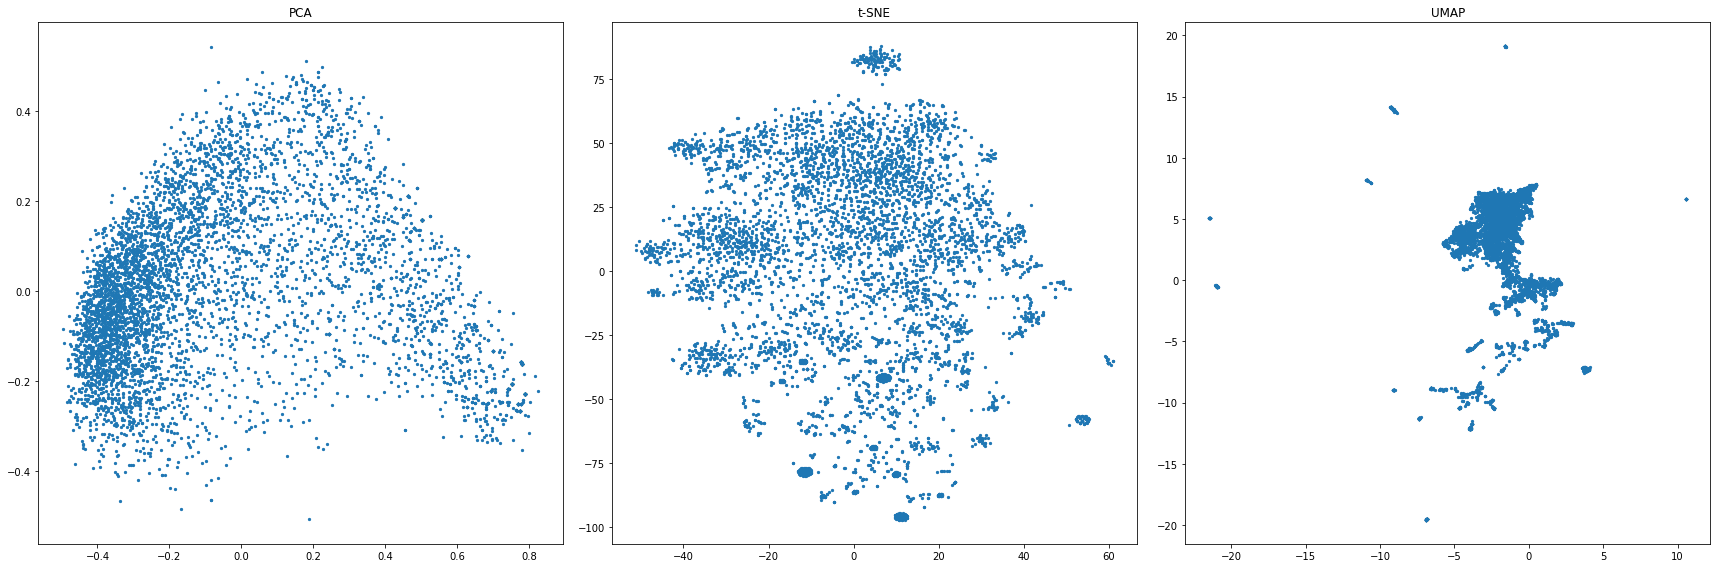

time: 905 ms


In [17]:
s = 5

plt.figure(figsize=(24,8))

plt.subplot(131)
plt.scatter(embedding_pca[:,0], embedding_pca[:,1],s=s)
plt.title('PCA')

plt.subplot(132)
plt.scatter(embedding_tsne[:,0], embedding_tsne[:,1],s=s)
plt.title('t-SNE')

plt.subplot(133)
plt.scatter(embedding_umap[:,0], embedding_umap[:,1],s=s)
plt.title('UMAP')

plt.tight_layout()
plt.show()

In [ ]:
nns = [2, 5, 10, 100, 500]
mds = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]

embedding_umap_hyper = []
for n_neighbours in nns:
    for min_dist in mds:
        embedding_umap_hyper.append(umap.UMAP(n_components=2,
                                              n_neighbors=n_neighbours,
                                              min_dist=min_dist,
                                              random_state=SEED).fit_transform(vectors_guse))
        


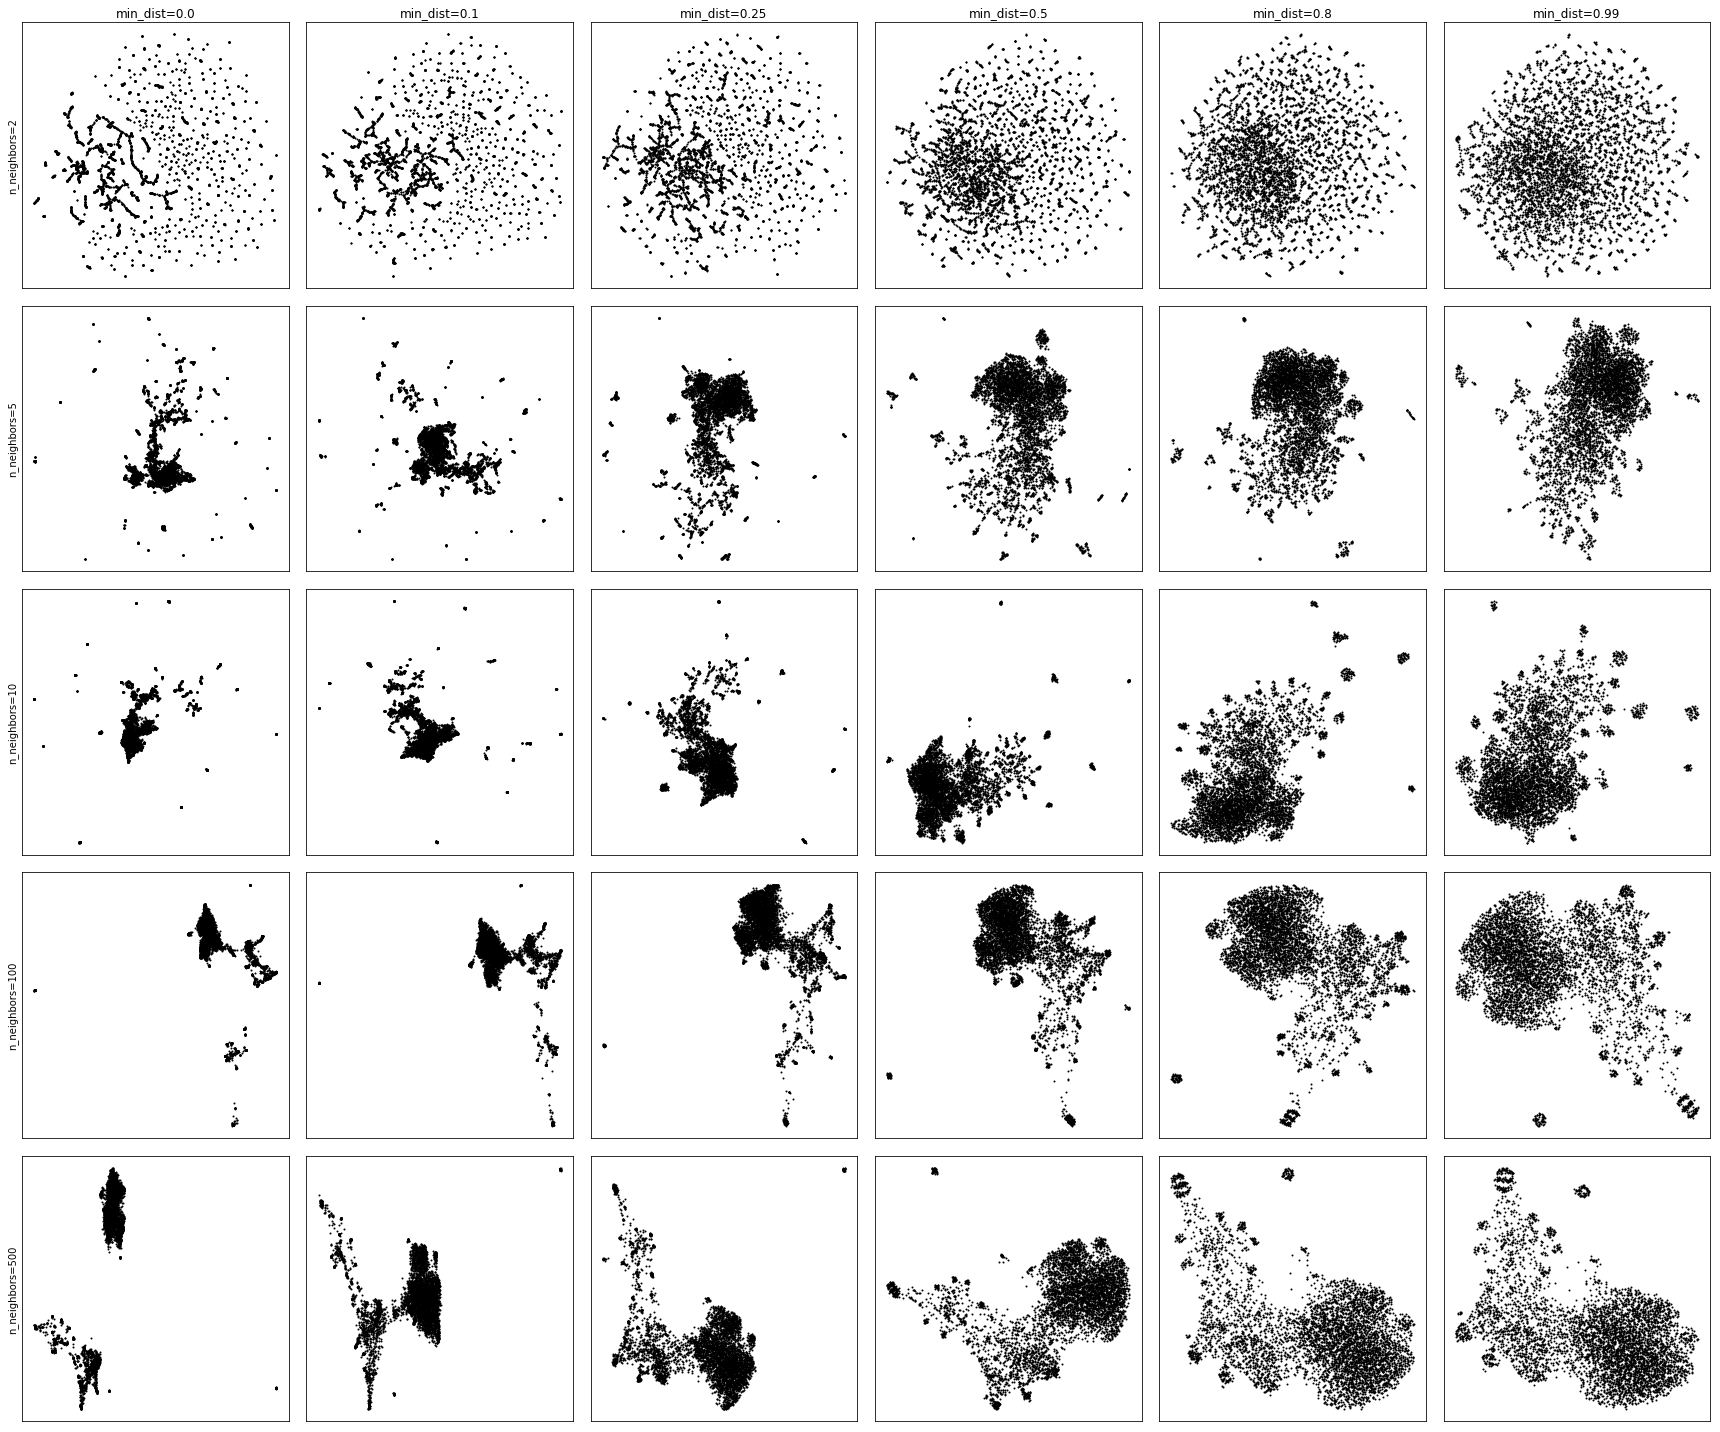

time: 3.24 s


In [20]:
plt.figure(figsize=(24,20))

for i in range(len(embedding_umap_hyper)):
    plt.subplot(5,6,i+1)
    plt.scatter(embedding_umap_hyper[i][:,0],embedding_umap_hyper[i][:,1], s=1, c='k')
    plt.xticks([],[])
    plt.yticks([],[])
    if i <= 5:
        plt.title('min_dist={}'.format(mds[i]))
    if i % 6 == 0:
        plt.ylabel('n_neighbors={}'.format(nns[int(i/6)]))
        
plt.tight_layout()
plt.show()

In [21]:
embedding_umap = umap.UMAP(n_components=2,
                           n_neighbors=100,
                           min_dist=0.8,
                           random_state=SEED).fit_transform(vectors_guse)

time: 31.9 s


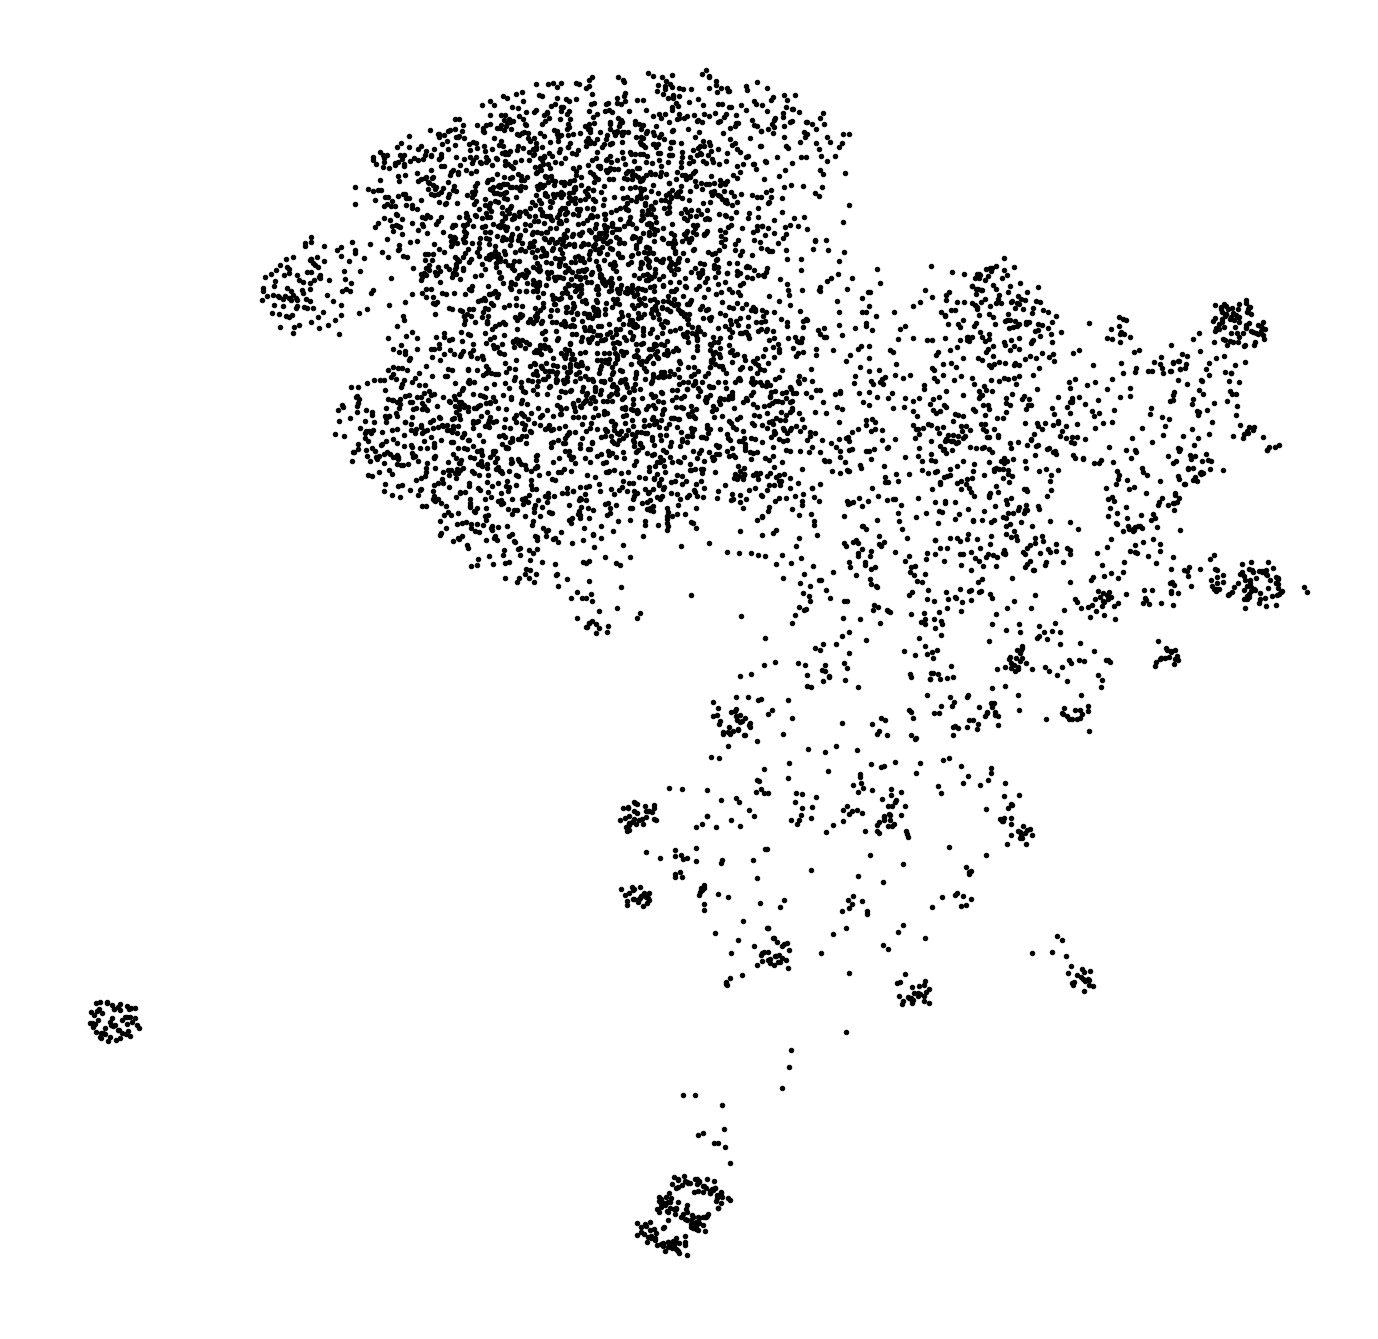

time: 951 ms


In [50]:
# Plot for presentation
plt.figure(figsize=(24,24), facecolor='w')
plt.scatter(embedding_umap[:,0], embedding_umap[:,1],s=20,c='k')
plt.axis('off')
plt.show()

In [47]:
# Plotly
layout = go.Layout(
    autosize=False,
    width=800,
    height=800,
    hovermode="closest"
)

data = [go.Scatter(
                x=embedding_umap[:,0],
                y=embedding_umap[:,1],
                text=df.textwrap,
                mode='markers',
                marker=dict(
                        size=5,
                        colorscale=matplotlib_to_plotly(plt.cm.viridis_r, 255),
                        color=0,
                        showscale=False
                )
)]

fig = go.Figure(data=data, layout=layout)

p = iplot(fig)

time: 449 ms


In [70]:
def detect_with_error(x):
    try:
        return detect(x)
    except:
        return None
    
df['word_count'] = df.review_body.map(lambda x: len(x.split(' ')))

time: 21.7 ms


In [72]:
idx = df.word_count > 3
vectors_cull = vectors_guse[idx,:]
embedding_cull = umap.UMAP(n_components=2, random_state=SEED).fit_transform(vectors_cull)

time: 9.77 s


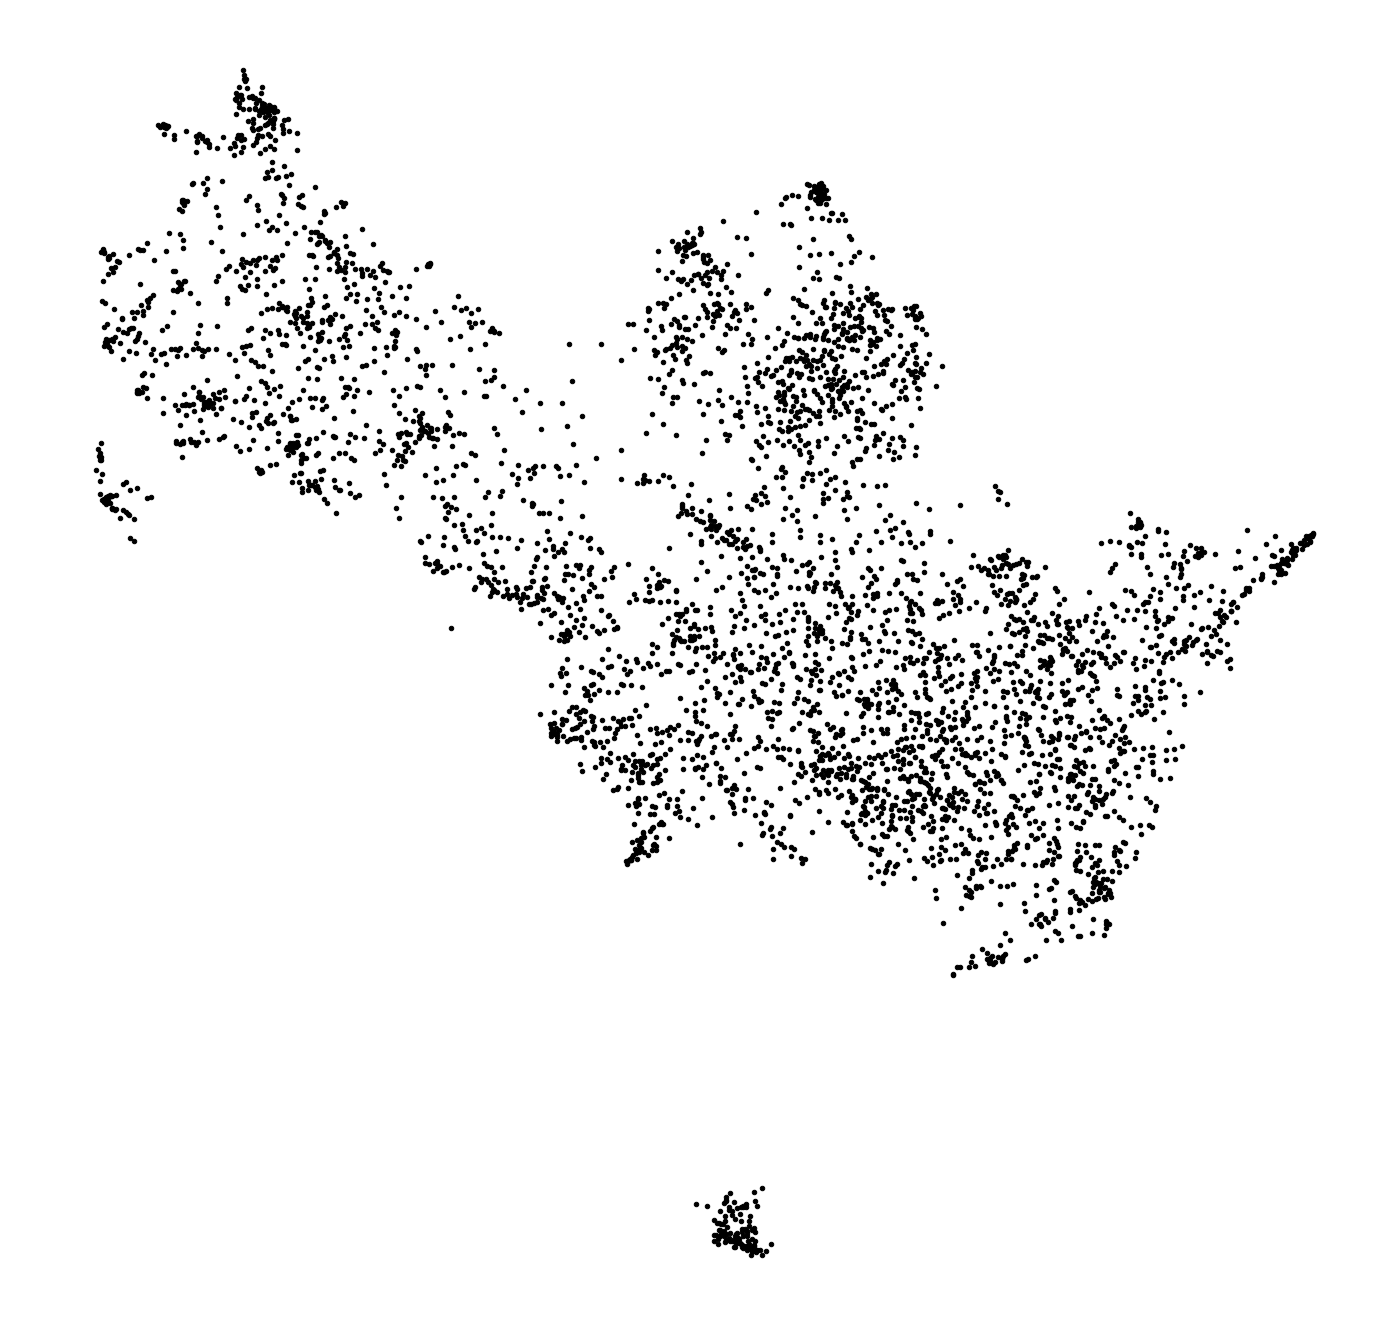

time: 970 ms


In [73]:
# Plot for presentation
plt.figure(figsize=(24,24), facecolor='w')
plt.scatter(embedding_cull[:,0], embedding_cull[:,1],s=20,c='k')
plt.axis('off')
plt.show()

In [75]:
# Plotly
layout = go.Layout(
    autosize=False,
    width=800,
    height=800,
    hovermode="closest"
)

data = [go.Scatter(
                x=embedding_cull[:,0],
                y=embedding_cull[:,1],
                text=df[idx].textwrap,
                mode='markers',
                marker=dict(
                        size=3,
                        colorscale=matplotlib_to_plotly(plt.cm.viridis_r, 255),
                        color=0,
                        showscale=False
                )
)]

fig = go.Figure(data=data, layout=layout)

p = iplot(fig)

time: 379 ms


In [76]:
df[df.review_body.str.contains('fog')]

review_id  star_rating  \
5441     R1V6ZJCMFM4IX0            5   
17993    R37GNYTWEUGOCR            5   
27456    R2QBGNNW4Y8JR5            5   
63593    R32JT811HFPH8O            5   
80594     ROOS90FMKPGSB            5   
128279   R1J23G8J2MQYYW            5   
145645   R2D4LUCBHY6BWZ            1   
151842   R1S0VJ00Q676SB            5   
187047   R3ANUNP6A3WAJH            5   
191593     R2T9FSXX2UTS            4   
220697   R188Z07DVUSO8P            5   
225502    RBP1PDB5TAM2E            5   
225556    RH24KSJHUPGJF            4   
226231    RAOSZ9TSAOR4X            5   
247569   R3JPVKR153CQZS            5   
258891   R1V2UC8BMU8X7J            5   
269666    RS70MTKCEGF7S            5   
302652   R1ITNYOIL6XBP7            5   
305093   R15Q5K2LFRJYJN            5   
336952   R2EB5METN0Q0JQ            4   
357797   R12W00WSHFH93R            4   
393968   R304I2HZQA7FHV            5   
397979    R4E6HB7BQCZAZ            5   
420848    R8H53A57JKD3D            5   
423966   R1DG9N6YJR8LSM            5   
447935   R2V5YDZTS1YQYV            5   
449166   R1K4Y9K55GAZ9U            5   
487145   R1Y9QEUMDJ1800            5   
517066    RTY5EXZ5ZWER9            5   
529306   R2NBEHKHVUK6W0            5   
...                 ...          ...   
720437   R3FN17QU5X1J0D            5   
768855   R1UGD774GJ60O0            5   
773618   R3CBEKADVSXGN1            4   
778164   R254STZLZQRBTT            4   
783326   R3VAX5VS2H12SO            3   
785266   R11MYAIFF097ST            3   
788021   R30RWPI59GRQP8            4   
817228   R1RYAMP96OT229            2   
819771    RJD4NVY7CRAMZ            4   
825435   R3OB2E3F9XMMLW            5   
843220    RKGG857RA65XK            5   
862874   R3DEU8DRUC2AVD            5   
867033   R3FINVTFF1XG6P            5   
874599   R1DY1NDTP6ICGF            4   
881612    R7NBQD6KLWI0B            5   
885393   R3RPS7PIHKT48F            5   
886317   R3H52FM3WQGDNC            5   
896380   R1RH1LZOIAKNK9            5   
912342   R3VQKE62GB9JFI            4   
922296   R3CWOD65ECSGC5            5   
934647   R1WLTEQZ63C3Y5            5   
948845   R3IGCDO2Z66X6X            3   
986728   R3S9J0TGNV4V93            5   
995486   R2WFIMAXLDDDI7            3   
1032669  R1YEFZ8WJ1KR9A            5   
1041729  R1O9TWQJ6SUB9F            5   
1045578   RXOJ1V7MGF6MU            3   
1076691   R8B647FFG9OYR            5   
1083909  R26T2AVQE8ORAR            5   
1159484   REOOS99SSMSDD            4   

                                           review_headline  \
5441                                      Helpful for sure   
17993      Dove with these about 8 times up to 65 feet ...   
27456                              expensive but they work   
63593    These work great! I was able to easily fit 3 o...   
80594                         Buy them! You will need them   
128279   These worked great. After recently moving to f...   
145645                                            One Star   
151842                                       Must have! =)   
187047                        Perfect for fogging problems   
191593                                          Four Stars   
220697                     Worked in my gopro diving fiji.   
225502   These work great! Haven't had an issue with th...   
225556     easy to use and reusable so I am happy with ...   
226231                                  Divers Best Friend   
247569                                 GoPro Wrist Housing   
258891   It is a must if you don't want fog in your gop...   
269666                                   Works every time!   
302652                                            Worth It   
305093                                   i guess they work   
336952   Great but difficult to insert on side of Hero ...   
357797                                          Four Stars   
393968                                          Five Stars   
397979           A must have for underwater or in the snow   
420848                                       

time: 48.7 ms


In [ ]:
dff = pd.read_csv('amazon_reviews_us_Camera_v1_00.tsv', sep='\t', error_bad_lines=False)
dff = dff[dff.product_title=='GoPro Head Strap Mount']

In [79]:
dff.groupby('product_id').agg({'review_id':'count'})

review_id
product_id           
B001MS6OM2        289
B002RCLYXG        917
B004M187ZI        228
B007J4BOWI        125
B009PK9UW0        105
B009QXFFYS        225
B00A3MY7KE         47
B00CTGGARU        144
B00EQ6JWX0          1
B00F19PYR4        867
B00F19PZXW        760
B00F19Q7AC        456
B00F19Q7YI        486
B00J9RO2LS         45
B00N31FQJS        149
B00NIYJL64        270
B00NIYNU8E        286
B00O12F210        209

time: 20.9 ms
